In [181]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from scipy.stats import entropy

## Algorithm Implementations

### PCA Implementation

In [10]:
import numpy as np

class MyPCA:
    def __init__(self, num_components=2):
        self.num_components = num_components

    def fit(self, X): # X is of shape (num_samples, num_features)
        #Subtract Means
        X_mean = np.mean(X, axis=0).reshape(1, -1)
        X_norm = (X - X_mean)

        #Calculate Covariance
        covariance = np.matmul(X_norm.transpose(), X_norm) / X_norm.shape[0]

        #Calculate Eigenvectors & Eigenvalues
        eigenvalues, eigenvectors = np.linalg.eig(covariance)

        #Sort Eigenvectros according to Eigenvalues
        idx = eigenvalues.argsort()[::-1]     
        sorted_vecs = (eigenvectors[:, idx])   
        eigenvalues = eigenvalues[idx]
        self.prinicple_components_ = sorted_vecs[:,:self.num_components] 
                
    def project(self, X):
        X_mean = np.mean(X, axis=0).reshape(1, -1)
        X_norm = (X - X_mean)
        return np.matmul(X_norm, self.prinicple_components_)

### K-Means Implementation

In [21]:
class MyKmeans:
    def __init__(self, num_centroids = 2, max_iters = 100, max_trials = 10):
        self.num_centroids = num_centroids
        self.max_iters = max_iters
        self.max_trials = max_trials

    def calculate_error(self, X, centroids, labels): #X: (num_samples, num_features), Labels: (num_samples), Centroids: (num_centroids, num_features)
        error = 0
        for i in range(self.num_centroids):
            cluster_points = X[labels==i]
            error += np.square(cluster_points - centroids[i]).sum() #Cluster Error
        return error


    def train_multiple_trials(self, X):
        min_error = float('inf')
        min_centroids = None
        min_labels = None

        for _ in range(self.max_trials):
            centroids, labels = self.train_fast(X)
            error = self.calculate_error(X, centroids, labels)
            if error < min_error:
                min_error = error
                min_centroids = centroids
                min_labels = labels

        return min_centroids, min_labels


    #Slower but simpler implementation
    def train(self, X): # X is of shape (num_samples, num_features)
        centroids = X[np.random.choice(range(X.shape[0]), self.num_centroids, replace=False)]
        for _ in range(self.max_iters):
            #Measure Distances to Centroids
            distances = np.zeros((X.shape[0], self.num_centroids)) #Shape: (num_samples, num_centroids)            
            for i in range(X.shape[0]):
                for j in range(self.num_centroids):
                    distances[i][j] = np.linalg.norm(X[i]-centroids[j])            

            #Assign Points to Clusters
            labels = np.argmin(distances, axis=1)

            new_centroids = np.zeros((self.num_centroids, X.shape[1]))
            #Recalculate Centroids
            for i in range(self.num_centroids):
                cluster_points = X[labels==i]
                new_centroids[i] = cluster_points.mean(axis=0)
            
            # Check convergence
            if np.all(centroids == new_centroids):
                break
            
            centroids = new_centroids
        
        return centroids, labels


    def train_fast(self, X): # X is of shape (num_samples, num_features)
        # Initialize centroids randomly
        centroids = X[np.random.choice(range(X.shape[0]), self.num_centroids, replace=False)]
        
        for _ in range(self.max_iters):
            # Assign each data point to the nearest centroid
            distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
            labels = np.argmin(distances, axis=1)
            
            # Update centroids
            new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(self.num_centroids)])
            
            # Check convergence
            if np.all(centroids == new_centroids):
                break
            
            centroids = new_centroids
        
        return centroids, labels

## Data Preparation

In [99]:
data =  pd.read_csv("data.csv")

data = data.drop(columns=['id', 'Unnamed: 32']) #Remove Unnecessary Columns
X = data.drop(columns=["diagnosis"])
y = data[["diagnosis"]]

In [100]:
#Normalizing Data
X_normalized = (X - X.mean()) / X.std()
X_normalized_arr = X_normalized.to_numpy()

## Experiment 1: K-Means Only

### Finding Best Number of Clusters Using Elbow Method

K found using elbow method = 15

In [42]:
k = [i+1 for i in range(30)]
errors = []

for i in k:
    k_means = MyKmeans(num_centroids=i, max_iters=100, max_trials=10)
    centroids, labels = k_means.train_multiple_trials(X_normalized_arr)
    errors.append(k_means.calculate_error(X_normalized_arr, centroids, labels))


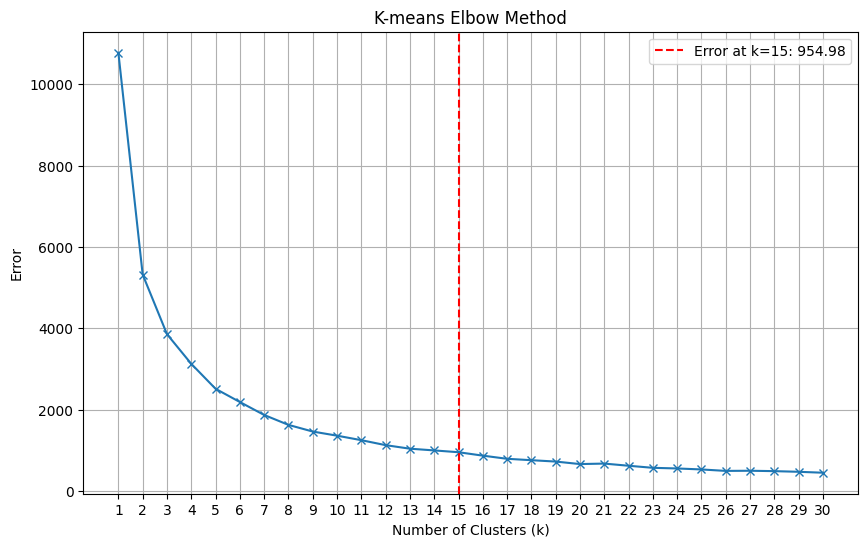

In [84]:
# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(k, errors, marker='x', linestyle='-')  
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Error')
plt.title('K-means Elbow Method')
plt.xticks(k)
plt.grid(True)
plt.axvline(x=15, color='red', linestyle='--', label=f'Error at k=15: {round(errors[14],2)}')
plt.legend()
plt.show()

## Experiment 2: K-Means & PCA

### Elbow Method for 2 Principal Components

In [145]:
pca = MyPCA(num_components=2)
pca.fit(X_normalized_arr)
X_pca = pca.project(X_normalized_arr)


k = [i+1 for i in range(30)]
errors_pca2 = []

for i in k:
    k_means = MyKmeans(num_centroids=i, max_iters=100, max_trials=10)
    centroids, labels = k_means.train_multiple_trials(X_pca)
    errors_pca2.append(k_means.calculate_error(X_pca, centroids, labels))


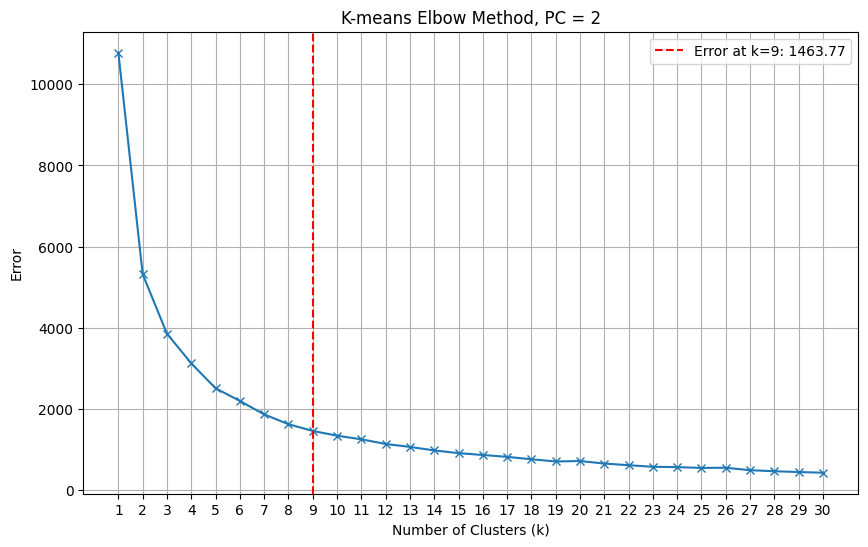

In [149]:
# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(k, errors_pca2, marker='x', linestyle='-')  # 'x' markers for data points, solid line
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Error')
plt.title('K-means Elbow Method, PC = 2')
plt.xticks(k)
plt.grid(True)
plt.axvline(x=9, color='red', linestyle='--', label=f'Error at k=9: {round(errors_pca2[8],2)}')
plt.legend()
plt.show()

### Elbow Method for 3 Principal Components

In [ ]:
pca = MyPCA(num_components=3)
pca.fit(X_normalized_arr)
X_pca = pca.project(X_normalized_arr)


k = [i+1 for i in range(30)]
errors_pca3 = []

for i in k:
    k_means = MyKmeans(num_centroids=i, max_iters=100, max_trials=10)
    centroids, labels = k_means.train_multiple_trials(X_pca)
    errors_pca3.append(k_means.calculate_error(X_pca, centroids, labels))

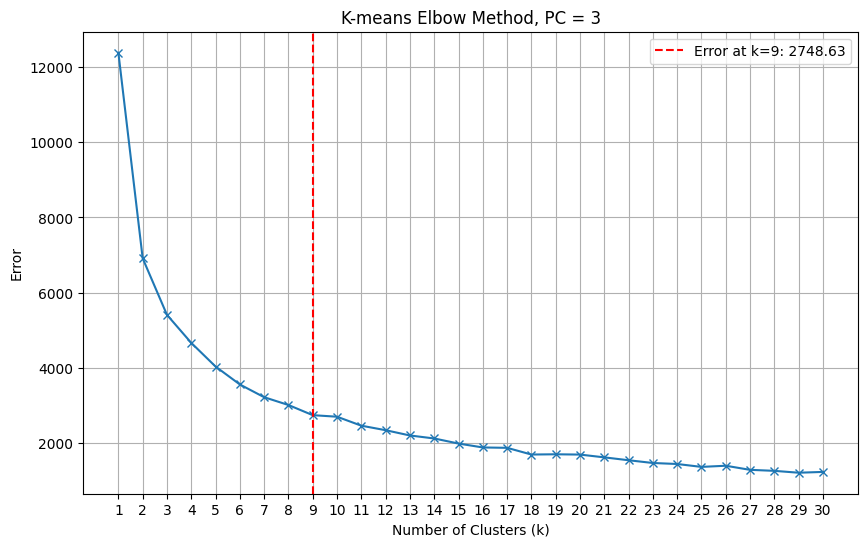

In [87]:
# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(k, errors_pca3, marker='x', linestyle='-')  # 'x' markers for data points, solid line
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Error')
plt.title('K-means Elbow Method, PC = 3')
plt.xticks(k)
plt.grid(True)
plt.axvline(x=9, color='red', linestyle='--', label=f'Error at k=9: {round(errors_pca3[8],2)}')
plt.legend()
plt.show()

### Elbow Method for 4 Principal Components

In [75]:
pca = MyPCA(num_components=4)
pca.fit(X_normalized_arr)
X_pca = pca.project(X_normalized_arr)


k = [i+1 for i in range(30)]
errors_pca4 = []

for i in k:
    k_means = MyKmeans(num_centroids=i, max_iters=100, max_trials=10)
    centroids, labels = k_means.train_multiple_trials(X_pca)
    errors_pca4.append(k_means.calculate_error(X_pca, centroids, labels))

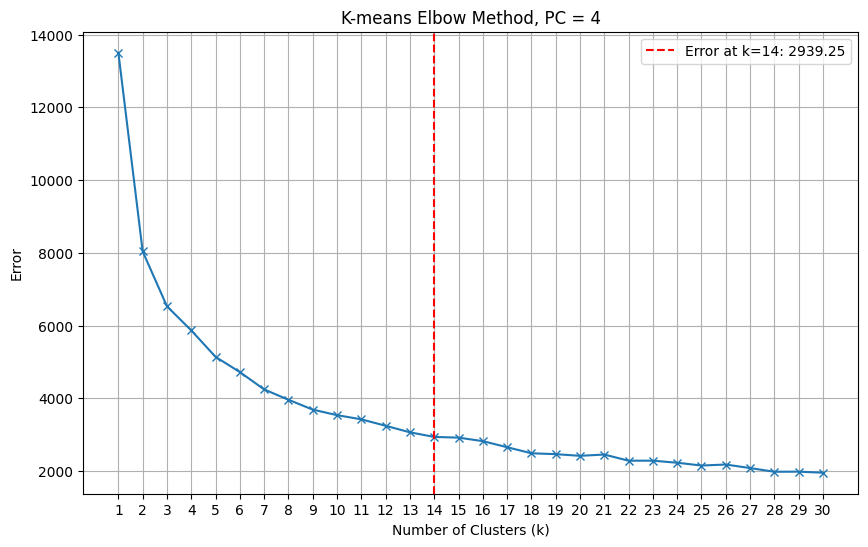

In [88]:
# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(k, errors_pca4, marker='x', linestyle='-')  # 'x' markers for data points, solid line
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Error')
plt.title('K-means Elbow Method, PC = 4')
plt.xticks(k)
plt.grid(True)
plt.axvline(x=14, color='red', linestyle='--', label=f'Error at k=14: {round(errors_pca4[13],2)}')
plt.legend()
plt.show()

### Elbow Method for 5 Principal Components

In [68]:
pca = MyPCA(num_components=5)
pca.fit(X_normalized_arr)
X_pca = pca.project(X_normalized_arr)


k = [i+1 for i in range(30)]
errors_pca5 = []

for i in k:
    k_means = MyKmeans(num_centroids=i, max_iters=100, max_trials=10)
    centroids, labels = k_means.train_multiple_trials(X_pca)
    errors_pca5.append(k_means.calculate_error(X_pca, centroids, labels))

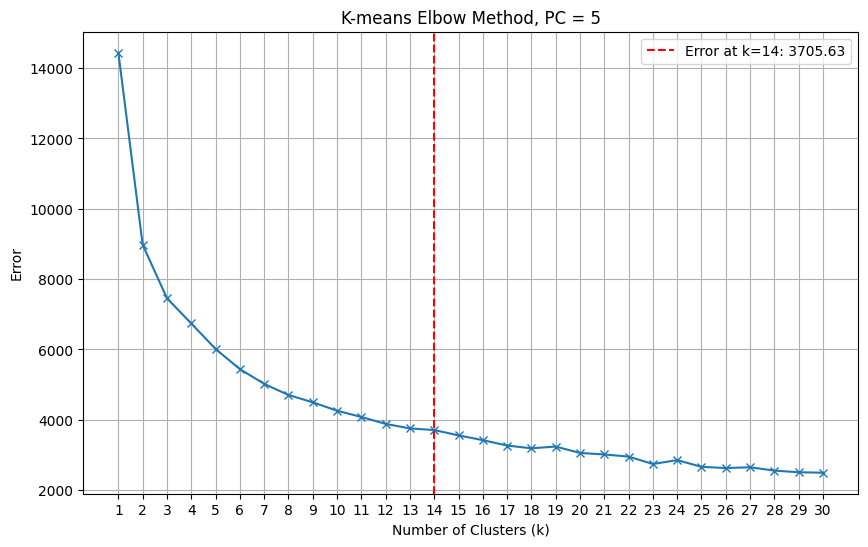

In [89]:
# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(k, errors_pca5, marker='x', linestyle='-')  # 'x' markers for data points, solid line
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Error')
plt.title('K-means Elbow Method, PC = 5')
plt.xticks(k)
plt.grid(True)
plt.axvline(x=14, color='red', linestyle='--', label=f'Error at k=14: {round(errors_pca5[13],2)}')
plt.legend()
plt.show()

### Visualizing Results

In [194]:
num_clusters = 9
pca = MyPCA(num_components=2)
pca.fit(X_normalized_arr)
X_pca = pca.project(X_normalized_arr)
k_means = MyKmeans(num_centroids=num_clusters, max_iters=100, max_trials=100)
centroids, labels = k_means.train_multiple_trials(X_pca)
X_pca_labeled = np.concatenate((X_pca, y), axis=1)

malignant_X = X_pca_labeled[X_pca_labeled[:,2]=='M']
benign_X = X_pca_labeled[X_pca_labeled[:,2]=='B']

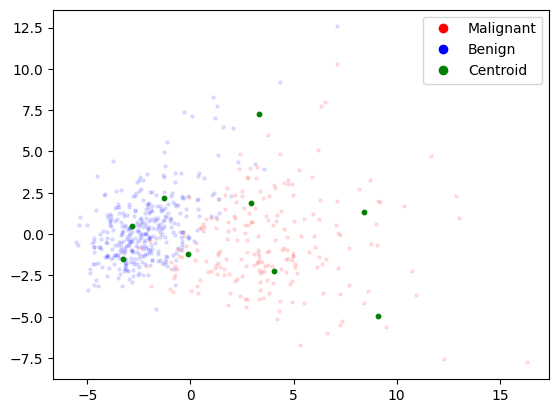

In [195]:
plt.scatter(malignant_X[:,0], malignant_X[:,1], c= 'r', s = 5, alpha=0.1)
plt.scatter(benign_X[:,0], benign_X[:,1], c= 'b', s=5, alpha=0.1)
plt.scatter(centroids[:,0], centroids[:,1], c= 'g', s=10)

# Create custom legend entries with desired appearance
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=8),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=8),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='g', markersize=8)
]

# Display the legend with custom legend entries
plt.legend(legend_elements, ["Malignant", "Benign", "Centroid"])
plt.show()

In [196]:
X_pca_clustered = np.concatenate((X_pca_labeled, labels.reshape(-1,1)), axis=1)
cluster_data = pd.DataFrame({
    'Component 1': X_pca_clustered[:, 0],
    'Component 2': X_pca_clustered[:, 1],
    'Target': X_pca_clustered[:, 2], 
    'Cluster': X_pca_clustered[:, 3]  
})

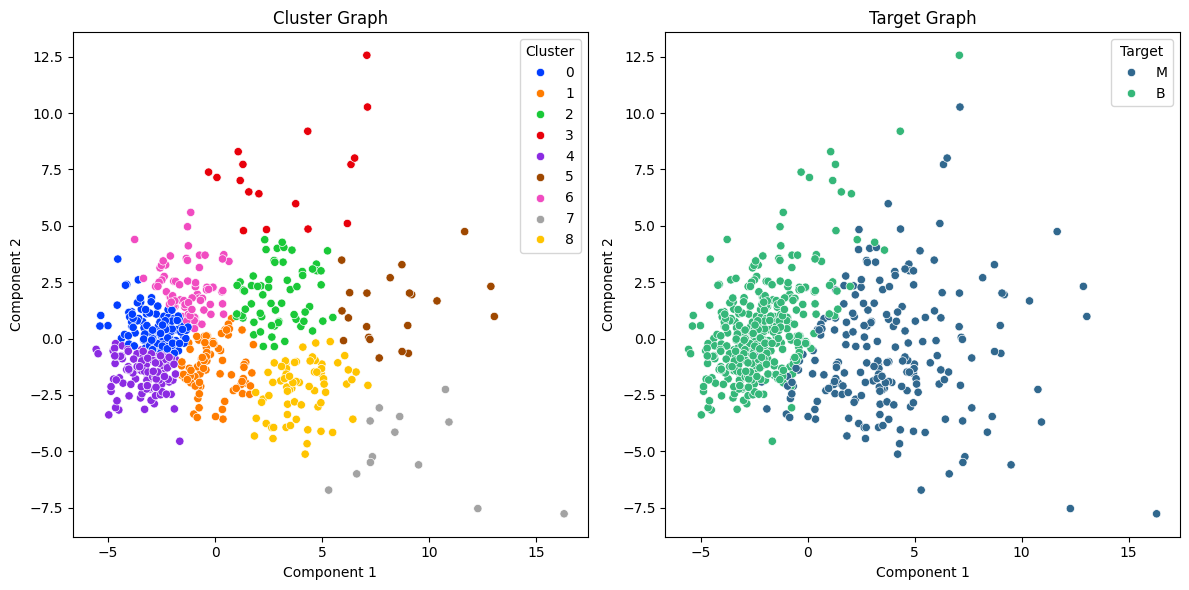

In [197]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))


sns.scatterplot(data=cluster_data, x='Component 1', y='Component 2', hue='Cluster', palette='bright', ax=axes[0])
axes[0].set_title('Cluster Graph')
axes[0].set_xlabel('Component 1')
axes[0].set_ylabel('Component 2')


sns.scatterplot(data=cluster_data, x='Component 1', y='Component 2', hue='Target', palette='viridis', ax=axes[1])
axes[1].set_title('Target Graph')
axes[1].set_xlabel('Component 1')
axes[1].set_ylabel('Component 2')

plt.tight_layout() 
plt.show()

### Extra(Entropy within each Cluster)

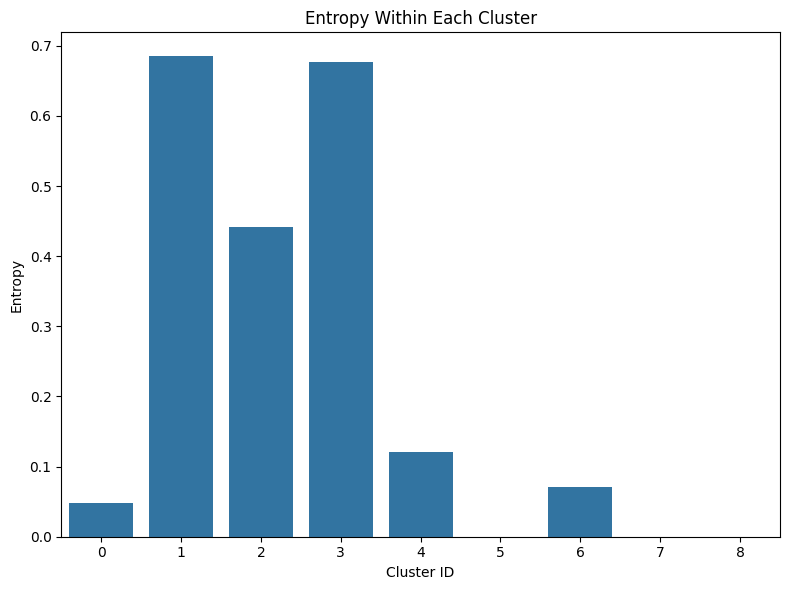

In [198]:
entropy_values = []

for i in range(num_clusters):
    cluster_points = cluster_data[cluster_data['Cluster'] == i]    
    
    # Calculate entropy for the target variable within the cluster
    target_distribution = cluster_points['Target'].value_counts(normalize=True)
    entropy_cluster = entropy(target_distribution)
    entropy_values.append(entropy_cluster)



plt.figure(figsize=(8, 6))
sns.barplot(x=[i for i in range(num_clusters)], y=entropy_values)
plt.xlabel('Cluster ID')
plt.ylabel('Entropy')
plt.title('Entropy Within Each Cluster')
plt.tight_layout()
plt.show()